In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
MIN_MATCH_COUNT = 10

# img1 = cv2.imread('images/uturn.jpg',0) # queryImage
img1 = cv2.imread('images/uturn_box.png',0) # queryImage

img2 = cv2.imread('images/bin_img_0100.jpg',0) # trainImage

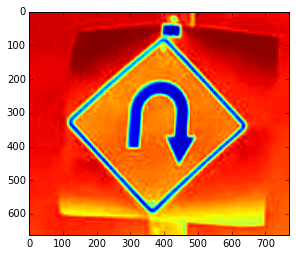

In [3]:
plt.imshow(img1)

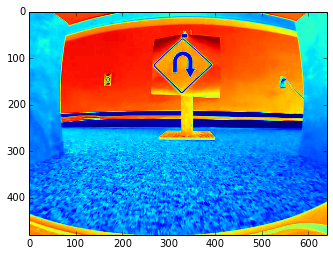

In [4]:
plt.imshow(img2)

In [5]:
# Initiate SIFT detector
sift = cv2.SIFT()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [6]:
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [7]:
# bf = cv2.BFMatcher()
# # matches = bf.knnMatch(des1, des2, k=2)

In [ ]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.85*n.distance:
        good.append(m)

In [ ]:
print len(good)
for match in sorted(good, key=lambda val: val.distance):
    print match.distance

In [ ]:
def drawMatches(img1, kp1, img2, kp2, matches, masks):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    masks - a list of which matches are inliers (1?) or outliers (0?)
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mask, mat in zip(masks,matches):

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        
        cv2.circle(out, (int(x1),int(y1)), 4, (255*mask, 0, 255*(1-mask)), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255*mask, 0, 255*(1-mask)), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    cv2.imshow('Matched Features', out)
    cv2.waitKey(0)
    cv2.destroyWindow('Matched Features')

    # Also return the image if you'd like a copy
    return out

In [ ]:
# Show only the top 10 matches - also save a copy for use later
# out = drawMatches(img1, kp1, img2, kp2, good[:15], mask)

In [ ]:
src_pts = np.float32([kp1[match.queryIdx].pt for match in good]).reshape(-1,1,2)
dst_pts = np.float32([kp2[match.trainIdx].pt for match in good]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

print M

print mask

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, M)



In [ ]:
out = drawMatches(img1, kp1, img2, kp2, good, matchesMask)